In [11]:
import networkx as nx
import numpy as np
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import pickle

In [12]:
#city = 'Utrecht'
#city_str = 'Utrecht, Netherlands'
#dist = 6500

city = 'Rotterdam'
city_str = 'Rotterdam, Netherlands'
dist = 8000
locations = ['centre','port']

In [13]:
filepath=f"./graphs/{city}.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
G = ox.load_graphml(filepath=filepath)

with open(f'./data/escape_nodes_{city}.pkl', 'rb') as f:
    escape_nodes = pickle.load(f)

for location in locations:
    with open(f'./data/fugitive_start_{city}_{location}.pkl', 'rb') as f:
        fugitive_start = pickle.load(f)

if city != 'Winterswijk':
    with open(f'./data/cameras_{city}.pkl', 'rb') as f:
        cameras = pickle.load(f)
elif city == 'Winterswijk':
    cameras = []

In [14]:
len(escape_nodes)

150

In [15]:
escape_nodes_filtered = []
for escape_node in escape_nodes:
    if G.has_node(escape_node):
        escape_nodes_filtered.append(escape_node)

with open('data/escape_nodes_{city}_filtered.pkl', 'wb') as f:
    pickle.dump(escape_nodes_filtered, f)

In [16]:
len(escape_nodes_filtered)

112

In [17]:
escape_nodes = escape_nodes_filtered.copy()

In [18]:
def draw_edges(graph):
    edges_fugitive = []

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [19]:
with open('data/fugitive_start_Rotterdam_centre.pkl', 'rb') as f:
    fugitive_start_centre = pickle.load(f)

with open('data/fugitive_start_Rotterdam_port.pkl', 'rb') as f:
    fugitive_start_port = pickle.load(f)

fugitive_starts = [
    ('centre', fugitive_start_centre),
    ('port', fugitive_start_port)
]

def draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes):
    node_size = []
    node_color = []
    for node in G.nodes:
        if node == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in cameras:
            node_size.append(10)
            node_color.append('tab:green')
        elif node in trafficlights:
            node_size.append(10)
            node_color.append('purple')
        elif node in roundabouts:
            node_size.append(10)
            node_color.append('gold')
        elif node in tunnels:
            node_size.append(10)
            node_color.append('aqua')
        elif node in bridges:
            node_size.append(10)
            node_color.append('royalblue')
        else:
            node_size.append(0)
            node_color.append('lightgray')
    return node_size, node_color

In [20]:
from matplotlib.lines import Line2D

def show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, location_name, save=False):
    edge_colormap, edge_weightmap = draw_edges(G)
    node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                )
    if save:
        custom_lines = [Line2D([0], [0], color='tab:orange', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:red', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:green', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='purple', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='gold', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='aqua', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='royalblue', marker='o', markersize=10, linestyle=''),
                        ]
        labels = ['start fugitive', 'escape node', 'cameras', 'traffic light', 'roundabout', 'tunnel', 'bridge']
        ax.legend(custom_lines, labels, bbox_to_anchor=(1.1, 1.05))
        fig.savefig(f'graphs/{city}_{location_name}.png', bbox_inches='tight', dpi=300)

In [78]:
for location_name, fugitive_start in fugitive_starts:
    show_graph(G, escape_nodes, fugitive_start, [], [], [], [], [], location_name, save=True)

In [21]:
roundabouts = []
for u,v, data in G.edges(data=True): 
    if 'junction' in data.keys():
        if data['junction'] == 'roundabout':
            roundabouts.append(u)
            roundabouts.append(v)
            
roundabouts = np.unique(roundabouts)

In [22]:
with open(f'./model_elements/roundabouts.pkl', 'wb') as f:
    pickle.dump(roundabouts, f)

In [23]:
#On roundabouts, the maximum speed is not a realistic speed to drive. So, for 50km/h roundabouts, a speed of 30 is set, and roundabouts of 80km/h a speed of 50km/h will be used

#Only when running for withtraffic (change manually)

for u, v, data in G.edges(data=True):
    if 'maxspeed' in data:
        if u in roundabouts and v in roundabouts:
            if data['maxspeed'] == 50:
                data['maxspeed'] = 30
                data['speed_kph'] = 30
            if data['maxspeed'] == 80:
                data['maxspeed'] = 50
                data['speed_kph'] = 50

In [82]:
#for traffic lights: 
# 1) import non-simplified graph
# 2) find all traffic lights and save lat/lon
# 3) find nearest node for each
# 4) add 'traffic_signals' tag

In [24]:
import networkx as nx
import osmnx as ox

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface', 
                    'traffic_signals', 'crossing']

ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork(city_str, dist):
    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential|unclassified"]' #busway

    ox.settings.log_console=True
    ox.settings.use_cache=True

    # download street network data from OSM and construct a MultiDiGraph model
    G = ox.graph_from_address(city_str, dist=dist, network_type='drive', simplify=False, custom_filter=cf)

    return G

G_notsimplified=generate_streetnetwork(city_str, dist)

In [84]:
len(G.nodes())

In [25]:
trafficlight_locs = []
for u, data in G_notsimplified.nodes(data=True): 
    if 'traffic_signals' in data.keys():
        trafficlight_locs.append(data)
    elif 'highway' in data.keys():
        if data['highway'] == 'traffic_signals':
            trafficlight_locs.append(data)
    elif 'crossing' in data.keys():
        if data['crossing'] == 'traffic_signals':
            trafficlight_locs.append(data)

In [26]:
import osmnx as ox
import numpy as np

trafficlights = []

for trafficlight_loc in trafficlight_locs:
    y_coord = trafficlight_loc['y']
    x_coord = trafficlight_loc['x']

    node_distances = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            node_y = G.nodes[node]['y']
            node_x = G.nodes[node]['x']
            distance = np.sqrt((y_coord - node_y)**2 + (x_coord - node_x)**2)
            node_distances[node] = distance

    nearest_node = min(node_distances, key=node_distances.get)
    trafficlights.append(nearest_node)

trafficlights = np.unique(trafficlights)

In [87]:
trafficlight_locs

In [134]:
len(trafficlights)

754

In [27]:
tunnels = []
for u, v, data in G.edges(data=True): 
    if 'tunnel' in data.keys():
        tunnels.append(u)
        tunnels.append(v)
            
tunnels = np.unique(tunnels)

In [28]:
bridges1 = []
for u, v, data in G.edges(data=True): 
    if 'bridge' in data.keys():
        if data['bridge'] == 'movable':
            bridges1.append(u)
            bridges1.append(v)
            
bridges1 = np.unique(bridges1)

array([  44419475,   44425711,   44580092,  791025558, 5775065222,
       6636541280], dtype=int64)

In [29]:
from pandas.io.json import json_normalize
import json

bridges_path = f'./data/bridges_rotterdam.json'
with open(bridges_path, 'r') as json_bestand:
    data = json.load(json_bestand)

# converteer json bestand naar een DataFrame
bridges_dataframe = json_normalize(data)

bridges_dataframe = bridges_dataframe[bridges_dataframe['type']=='node']
bridges_dataframe = bridges_dataframe[['id','lat','lon']]
bridges_dataframe

C:\Users\Veerle\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,id,lat,lon
23,5313597287,51.906264,4.448596
24,5313597288,51.906276,4.448055
25,5313597289,51.906242,4.448055
26,5313597290,51.906232,4.448592
27,8437277790,51.916638,4.443798
...,...,...,...
146,2405631460,51.921322,4.498191
147,2405631461,51.921037,4.498107
148,2405631469,51.921119,4.498362
149,745637382,51.955601,4.518518


In [30]:
bridges = []
for i in bridges_dataframe:
    dichtstbijzijnde_node = ox.nearest_nodes(G, bridges_dataframe['lon'], bridges_dataframe['lat'])
    bridges.append(dichtstbijzijnde_node)
bridges = np.unique(bridges)

In [93]:
# for location_name, fugitive_start in fugitive_starts:
#     #show_graph(G, escape_nodes, fugitive_start, [], [], [], [], [], location_name, save=True)
#     show_graph(G, [], fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, location_name, save=True)

Congestion factor

In [31]:
congestion_travel_time_dict = {}
for u, v, z, data in G.edges(data=True, keys=True):
    if data['highway'] in ['trunk', 'primary']:
        congestion_factor = 1.75
    elif data['highway'] in ['motorway']:
        congestion_factor = 2
    elif data['highway'] in ['secondary']:
        congestion_factor = 1.5
    elif data['highway'] in ['tertiary']:
        congestion_factor = 1.25
    else:
        congestion_factor = 1

    data['congestion_factor'] = congestion_factor
    travel_time_with_congestion = float(data['travel_time'] * data['congestion_factor'])

    congestion_travel_time_dict[(u, v, z)] = travel_time_with_congestion

for u, v, z, data in G.edges(data=True, keys=True):
    if 'lanes' in data:
        if data['lanes'] == '1' and data['highway'] in ['trunk', 'primary', 'secondary']:
            data['congestion_factor'] += 0.2
            travel_time_with_congestion = float(data['travel_time'] * data['congestion_factor'])
            congestion_travel_time_dict[(u, v, z)] = travel_time_with_congestion

nx.set_edge_attributes(G, congestion_travel_time_dict, "travel_time_with_congestion")

In [96]:
color_map = {
    2: 'darkred',
    1.95: 'darkred',
    1.75: 'red',
    1.7: 'red',
    1.5: 'orange',
    1.25: 'yellow',
    1: 'lightgray',
}

fig, ax = plt.subplots(figsize=(15, 8))
edge_size = []
edge_width = []
node_color = []
for u, v, data in G.edges(data=True):
    congestion_factor = data.get('congestion_factor', 1)
    color = color_map.get(congestion_factor, 'lightgray')

    edge_size.append(color)
    edge_width.append(1)

node_color = ["lightgray" for node in G.nodes()]
node_size = [0 for node in G.nodes()]

# Plot de grafiek
ox.plot.plot_graph(
    G, ax=ax,
    bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_width, edge_color=edge_size,
    save=False, close=False
);


Loop through all edges in graph. If u/v has camera/traffic light/roundabout/etc, add time to travel_time of edge. e.g. 30 sec for camera, 10 sec for traffic light, 5 for roundabout (bc multiple nodes)?

In [32]:
camera_extra_time = 30
roundabout_extra_time = 5
trafficlight_extra_time = 30 #in literatuur: disutility gevonden van 20-40 seconden per verkeerslicht
tunnel_extra_time = 15 # want tunnel wordt als claustrofobischer ervaren dan brug
bridge_extra_time = 10

travel_time_dict = {}
for u, v, z, data in G.edges(data=True,keys=True):
    travel_time_adj = data['travel_time_with_congestion'] # of travel_time_with_congestion in geval met traffic
#om te voorkomen dat ze gelijk de snelweg opgaan
    if data['highway'] in ['motorway', 'trunk', 'primary']:
        travel_time_adj += 40

    if u in cameras:
        travel_time_adj += camera_extra_time
    if u in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if u in roundabouts:
        travel_time_adj += roundabout_extra_time
    if u in tunnels:
        travel_time_adj += tunnel_extra_time
    if u in bridges:
        travel_time_adj += bridge_extra_time

    if v in cameras:
        travel_time_adj += camera_extra_time
    if v in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if v in roundabouts:
        travel_time_adj += roundabout_extra_time
    if v in tunnels:
        travel_time_adj += tunnel_extra_time
    if v in bridges:
        travel_time_adj += bridge_extra_time
    travel_time_dict[(u, v, z)] = float(travel_time_adj)

nx.set_edge_attributes(G, travel_time_dict, "travel_time_adj")

In [33]:
for location_name, fugitive_start in fugitive_starts:
    route_fugitive = []
    while len(route_fugitive) < 1000:
        for escape_node in escape_nodes_filtered:
            try:
                path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
                route_fugitive.append(path)
            except:
                continue

#save the graph according to the right name (change manually)
    with open(f'data/escape_routes_Rotterdam_{location_name}_withtraffic.pkl', 'wb') as f:
        pickle.dump(route_fugitive, f)

In [103]:
escape_nodes

[44554760,
 44409874,
 1403932179,
 44467732,
 2805850135,
 44476443,
 603022362,
 4818915358,
 44156963,
 4818915364,
 4526122543,
 44444721,
 44500536,
 2603401279,
 44260928,
 44164163,
 2603401292,
 331166803,
 2603401300,
 1352714332,
 322017885,
 44702815,
 44171879,
 44349037,
 2603401325,
 1367194737,
 5390784116,
 44449398,
 44355197,
 1367194750,
 44440194,
 44429449,
 44440724,
 44174485,
 1367194774,
 44468388,
 44564644,
 44463270,
 44177581,
 8432860337,
 44224179,
 44630195,
 288169675,
 44543693,
 323145423,
 1030937303,
 44463835,
 621490909,
 44463844,
 3647991524,
 44254956,
 44547308,
 44187376,
 44596978,
 44177139,
 322906357,
 44478198,
 322070776,
 2545482491,
 4461994752,
 44426497,
 44158213,
 44206856,
 330658056,
 44443914,
 44170518,
 2545482520,
 1311152413,
 1250244897,
 44392228,
 44221221,
 44473124,
 275904807,
 44436264,
 44299057,
 1404073778,
 1402598708,
 275902274,
 44185923,
 44485447,
 44154184,
 44142413,
 44372815,
 322906465,
 944517988,
 444

In [104]:
len(route_fugitive)

1008

In [105]:
# # # nx.draw_networkx_edges(G,edgelist=path_edges,edge_color='r',width=10)
# #node_size, node_color = draw_nodes(G, fugitive_start, [], [], [], [], [], escape_nodes)
# #G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes): #cameras
# node_size, node_color = draw_nodes(G, fugitive_start, [], [], [], [], [], escape_nodes)
# edge_colormap, edge_weightmap = draw_edges(G)
#
# fig, ax = ox.plot_graph_routes(G, route_fugitive,
#                                route_linewidths=1, orig_dest_size=0,
#                                edge_linewidth=edge_weightmap, edge_color=edge_colormap,
#                                node_color=node_color, node_size=node_size,
#                                bgcolor="white", )
#
# fig.savefig(f'{city}_cool.png', bbox_inches='tight', dpi=300)

Politiebureaus en verplaatsingsnelheid

In [111]:
locations2 = [(4.48020, 51.92399), (4.49594, 51.90196)]
locations4 = [(4.49594, 51.90196), (4.48020, 51.92399), (4.55229, 51.94875), (4.482000, 51.8756)]

def save_police_data(locations, number_units):
    politie_bureau = []
    delay = []
    for location in locations:
        dichtstbijzijnde_node = ox.nearest_nodes(G, location[0], location[1])
        politie_bureau.append(dichtstbijzijnde_node)
        delay.append(0)

    with open(f'./data/optimization/start_police_{city}_{number_units}.pkl', 'wb') as f:
        pickle.dump(politie_bureau, f)

    with open(f'./data/optimization/delays_police_{city}_{number_units}.pkl', 'wb') as f:
        pickle.dump(delay, f)

save_police_data(locations2, '2')
save_police_data(locations4, '4')

In [112]:
# def show_polities(G):
#     # Locaties van de politiebureaus (lon, lat)
#     locations2 = [(4.48020, 51.92399), (4.49594, 51.90196)]
#     locations4 = [(4.49594, 51.90196), (4.48020, 51.92399), (4.55229, 51.94875), (4.482000, 51.8756)]
#
#     # Vind de dichtstbijzijnde knooppunten voor elke locatie
#     politie_bureau = [ox.nearest_nodes(G, lon, lat) for lon, lat in locations4]
#
#
#     # Configureer de kleuren en groottes van de knooppunten
#     node_size = []
#     node_color = []
#     for node in G.nodes:
#         if node in politie_bureau:
#             node_size.append(40)
#             node_color.append('tab:blue')
#         else:
#             node_size.append(0)
#             node_color.append('lightgray')
#
#     edge_colormap, edge_weightmap = draw_edges(G)
#
#     fig, ax = ox.plot_graph(
#         G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap, show=False
#     )
#
#     plt.show()
#
# show_polities(G)

In [34]:
police_travel_time_dict = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'lanes' in data:
        if data['lanes'] == 1:
            police_travel_time = data['travel_time']/1.1
            police_travel_time_dict[(u, v, z)] = float(police_travel_time)
        else:
            police_travel_time = data['travel_time']/1.3
            police_travel_time_dict[(u, v, z)] = float(police_travel_time)

nx.set_edge_attributes(G, police_travel_time_dict, "police_travel_time")

police_travel_time_dict_traffic = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict_traffic[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'lanes' in data:
        if data['lanes'] == 1:
            police_travel_time_traffic = data['travel_time_with_congestion']/1.1
            police_travel_time_dict_traffic[(u, v, z)] = float(police_travel_time_traffic)
    else:
        police_travel_time_traffic = data['travel_time_with_congestion']/1.3
        police_travel_time_dict_traffic[(u, v, z)] = float(police_travel_time_traffic)

nx.set_edge_attributes(G, police_travel_time_dict_traffic, "police_travel_time_traffic")

police_travel_time_dict_eval = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict_eval[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'police_travel_time_traffic' in data and 'police_travel_time' in data:
        police_travel_time_eval = (data['police_travel_time'] + data['police_travel_time_traffic'])/2
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    elif 'police_travel_time_traffic' in data:
        police_travel_time_eval = data['police_travel_time_traffic']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    elif 'police_travel_time' in data:
        police_travel_time_eval = data['police_travel_time']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    else:
        police_travel_time_eval = data['travel_time']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)

nx.set_edge_attributes(G, police_travel_time_dict_eval, "police_travel_time_eval")

In [35]:
# save graph accordingly (change manually)
filepath=f"./graphs/{city}_withtraffic_prepped.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
ox.save_graphml(G,filepath)

Trafficlight categories

In [115]:
primary_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    # Controleer of alle buren van de huidige node 'primary' of 'trunk' wegen zijn
    if all(data['highway'] == 'primary' or data['highway'] == 'trunk' for _, _, data in G_notsimplified.edges(node, data=True)):
        # Voeg de node toe aan de lijst als alle buren 'primary' of 'trunk' wegen zijn en er een verkeerslicht op de node is
        if node in trafficlights:
            primary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primary_trafficlight_nodes = list(set(primary_trafficlight_nodes))
print("Nodes waar alleen 'primary' of 'trunk' wegen samenkomen en waarop een verkeerslicht staat:", primary_trafficlight_nodes)
print('Het zijn er', len(primary_trafficlight_nodes))

Nodes waar alleen 'primary' of 'trunk' wegen samenkomen en waarop een verkeerslicht staat: [1435028993, 44366722, 1027160451, 4609552133, 4893441413, 5313487237, 44344079, 44378898, 44153108, 44370966, 1027160470, 1027231640, 44378905, 4336525732, 1027160486, 44152359, 745765801, 44492717, 4541858605, 1027160502, 44496951, 1737484856, 44153532, 44391752, 1687745613, 44374993, 44495574, 1465648217, 582730460, 44341341, 44149342, 987492067, 768903396, 3428185955, 582730470, 3428185957, 3428185961, 3428185965, 4893350894, 10734992621, 582730483, 11230989181, 44148222]
Het zijn er 43


In [116]:
primarysecondary_trafficlight_nodes = []

for node in G_notsimplified.nodes():
    primary_found = False
    secondary_found = False

    for _, _, data in G_notsimplified.edges(node, data=True):
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        elif data.get('highway') == 'secondary':
            secondary_found = True

    if primary_found and secondary_found and node in trafficlights:
        primarysecondary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarysecondary_trafficlight_nodes = list(set(primarysecondary_trafficlight_nodes))
print("Nodes waar zowel 'primary' of 'trunk' als 'secondary' wegen samenkomen en waarop een verkeerslicht staat:", primarysecondary_trafficlight_nodes)
print('Het zijn er', len(primarysecondary_trafficlight_nodes))

Nodes waar zowel 'primary' of 'trunk' als 'secondary' wegen samenkomen en waarop een verkeerslicht staat: [44233216, 2784433793, 1435580676, 44564363, 44273038, 44342670, 726833427, 735555481, 768935962, 768935963, 622670754, 1435580711, 44290473, 987492137, 44448301, 44201522, 44185527, 1435580729, 622670909, 602273346, 44529099, 602273358, 44235360, 736825314, 44156136, 3730829929, 670854762, 987492075, 44157420, 1434930157, 745765622, 312642167, 1433962105, 770739582]
Het zijn er 34


In [117]:
primarytertiary_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    primary_found = False
    tertiary_found = False

    # Loop door alle buren van de huidige node
    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'primary' of 'trunk' aansluit op de node
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        # Controleer of er een weg van het type 'tertiary' aansluit op de node
        elif data.get('highway') == 'tertiary':
            tertiary_found = True

    # Voeg de node toe aan de lijst als zowel een 'primary' of 'trunk' weg als een 'tertiary' weg aansluiten en er een verkeerslicht op de node is
    if primary_found and tertiary_found and node in trafficlights:
        primarytertiary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarytertiary_trafficlight_nodes = list(set(primarytertiary_trafficlight_nodes))
print("Nodes waar zowel 'primary' of 'trunk' als 'tertiary' wegen samenkomen en waarop een verkeerslicht staat:", primarytertiary_trafficlight_nodes)
print('Het zijn er', len(primarytertiary_trafficlight_nodes))

Nodes waar zowel 'primary' of 'trunk' als 'tertiary' wegen samenkomen en waarop een verkeerslicht staat: [1435580552, 44265877, 44548375, 622670751, 44262688, 622670888, 622670890, 745722541, 44262196, 622670901, 1435580606, 44442691, 44546770, 1434930131, 736865364, 44266457, 1434870237, 1434870238, 771254627, 44379364, 44548838, 44190704, 44546173]
Het zijn er 23


In [118]:
primaryresidential_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    residential_found = False
    primary_found = False

    # Loop door alle buren van de huidige node
    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'residential' aansluit op de node
        if data.get('highway') == 'residential':
            residential_found = True
        # Controleer of er een weg van het type 'tertiary' aansluit op de node
        elif data.get('highway') == 'primary':
            primary_found = True

    # Voeg de node toe aan de lijst als zowel een 'residential' weg als een 'tertiary' weg aansluiten en er een verkeerslicht op de node is
    if residential_found and primary_found and node in trafficlights:
        primaryresidential_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primaryresidential_trafficlight_nodes = list(set(primaryresidential_trafficlight_nodes))
print("Nodes waar zowel 'residential' als 'primary' wegen samenkomen en waarop een verkeerslicht staat:", primaryresidential_trafficlight_nodes)
print('Het zijn er', len(primaryresidential_trafficlight_nodes))

Nodes waar zowel 'residential' als 'primary' wegen samenkomen en waarop een verkeerslicht staat: [44257414, 670854663, 670854667, 791142546, 44259091, 1456279827, 44238077, 5313486109, 44262688, 10703013793, 1434991140, 44269104, 1612095282, 44256947, 44263479, 670854718, 4889760069, 44252488, 4718179285, 44244071, 44390125, 44268910, 44378360, 44265337, 1027273341, 44238079]
Het zijn er 26


With tram

In [119]:
useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name',
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing', 'railway',
                    'railway=tram', 'tram=yes', 'tram:lanes=*',
                    'highway=busway']


ox.settings.useful_tags_way=useful_tags_path

def generate_tramnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    railway_filter = '["railway"~"tram"]'


    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
    T = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, simplify=True, custom_filter=railway_filter)


    return T

In [120]:
T=generate_tramnetwork()

In [121]:
# #Tramlijnen tekenen
fig, ax = ox.plot_graph(
   T, bgcolor="white", node_color="lightgray", node_size=1, edge_linewidth=1, edge_color="lightgray",
   save=False)

In [122]:
def get_node_coordinates(graph):
    coordinates = []
    for node, data in graph.nodes(data=True):
        coord = (data['y'], data['x'])
        coordinates.append(coord)
    return coordinates

node_coordinates = get_node_coordinates(T)

tram_nodes = []
for coord in node_coordinates:
    nearest_node = ox.nearest_nodes(G, coord[1], coord[0])
    tram_nodes.append(nearest_node)

In [123]:
intersection_with_tram = []
for node in tram_nodes:
    if node in trafficlights:
        intersection_with_tram.append(node)
#intersection_with_tram

In [124]:
with open(f'./model_elements/intersection_withtram.pkl', 'wb') as f:
    pickle.dump(intersection_with_tram, f)

Green Wave

In [126]:
traffic_lights_within_150m = []

# Itereer over elk paar stoplichten en controleer of er een kort pad is binnen 150 meter
for source in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
    for target in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
        if source != target and nx.has_path(G, source=source, target=target):
            path_length = nx.shortest_path_length(G, source=source, target=target, weight='length')
            if path_length < 150:
                traffic_lights_within_150m.append(source)
                break  # Omdat we alleen willen weten of er een kort pad is, kunnen we stoppen met zoeken naar andere stoplichten

print(traffic_lights_within_150m)

[1435028993, 1027160451, 44344079, 44152359, 44492717, 4541858605, 1027160502, 44496951, 1687745613, 44374993, 44495574, 1465648217, 582730460, 44341341, 582730470, 582730483]


In [127]:
with open(f'./model_elements/green_wave.pkl', 'wb') as f:
    pickle.dump(traffic_lights_within_150m, f)

In [128]:
green_wave_road = []
cross_green_wave_road = []
for u,v,data in G.edges(data=True):
    if 'highway' in data.keys():
        if data['highway']=='primary' or data['highway']=='trunk':
            if u in traffic_lights_within_150m and v in traffic_lights_within_150m:
                green_wave_road.append([u,v])
        elif v in traffic_lights_within_150m:
            cross_green_wave_road.append([u,v])

print('greenwave road', green_wave_road)
print('cross road', cross_green_wave_road)

greenwave road [[582730483, 44341341], [44341341, 1435028993], [1435028993, 44344079], [582730470, 582730460], [582730460, 582730483]]
cross road [[44151553, 44152359], [1027160420, 1027160451], [3665848146, 1687745613], [44293929, 1465648217], [44335894, 582730483], [610226818, 582730470], [44397464, 44374993], [44484007, 4541858605], [610226815, 582730460], [1352714332, 44496951], [1434991598, 44492717]]


In [129]:
with open(f'./model_elements/green_wave_road.pkl', 'wb') as f:
    pickle.dump(green_wave_road, f)

with open(f'./model_elements/cross_green_wave_road.pkl', 'wb') as f:
    pickle.dump(cross_green_wave_road, f)

Default category

In [130]:
default = []

for node in trafficlights:
    # Controleer of de node niet in een van de andere lijsten zit
    if node not in intersection_with_tram and node not in traffic_lights_within_150m:
        default.append(node)

with open(f'./model_elements/default.pkl', 'wb') as f:
    pickle.dump(default, f)


In [131]:
traffic_light_categories = {}

def add_nodes_to_dict(nodes, list_name):
    for node in nodes:
        if isinstance(node, (str, int, float, tuple, int, np.integer)):
            traffic_light_categories[node] = list_name
        elif isinstance(node, list) and all(isinstance(item, (str, int, float, tuple, np.integer)) for item in node):
            traffic_light_categories[tuple(node)] = list_name
        else:
            print(f"Skipping invalid node {node} in list {list_name}, type {type(node)}")

add_nodes_to_dict(intersection_with_tram, 'intersection_with_tram')
add_nodes_to_dict(default, 'default')
add_nodes_to_dict(traffic_lights_within_150m, 'green_wave')
# add_nodes_to_dict(cross_green_wave_road, 'cross_green_wave')
# add_nodes_to_dict(green_wave_road, 'green_wave')

print(traffic_light_categories)
with open(f'./model_elements/traffic_light_categories.pkl', 'wb') as f:
    pickle.dump(traffic_light_categories, f)

{1030572746: 'intersection_with_tram', 1445795627: 'intersection_with_tram', 1426610337: 'intersection_with_tram', 597440929: 'intersection_with_tram', 603233348: 'intersection_with_tram', 44326564: 'intersection_with_tram', 558864428: 'intersection_with_tram', 44378905: 'intersection_with_tram', 582730470: 'green_wave', 1435028993: 'green_wave', 44342670: 'intersection_with_tram', 44341341: 'green_wave', 1426610335: 'intersection_with_tram', 44225957: 'intersection_with_tram', 1435580552: 'intersection_with_tram', 582611814: 'intersection_with_tram', 6486507707: 'intersection_with_tram', 322070776: 'intersection_with_tram', 11834957298: 'intersection_with_tram', 2462046181: 'intersection_with_tram', 322058115: 'intersection_with_tram', 1687745613: 'green_wave', 1612095282: 'intersection_with_tram', 1435580729: 'intersection_with_tram', 558864300: 'intersection_with_tram', 44411338: 'intersection_with_tram', 4691536387: 'intersection_with_tram', 6907592168: 'intersection_with_tram', 44

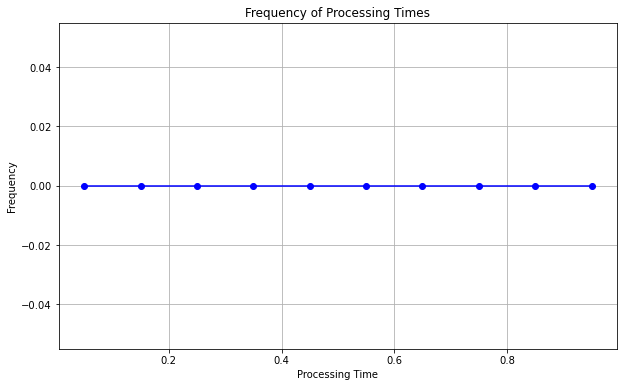

In [10]:
import pickle
import numpy as np

with open(f'results/wait_time_list_hot.pkl', 'rb') as f:
    processing_times = pickle.load(f)

# Define the number of bins for the histogram
num_bins = 10

# Create the histogram
counts, bin_edges = np.histogram(processing_times, bins=num_bins)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, counts, marker='o', linestyle='-', color='b')
plt.title('Frequency of Processing Times')
plt.xlabel('Processing Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()